# Coral and Model Record Comparison Analyses
### Figure Content:
 - **Main Text Figure 2:** Geochemical and model records of 20th century acidification in the California Current
 - **Extended Data Table 4:** West Coast coral $p$CO$_2$ and pH values (total scale) informed by skeletal δ11B
 --------------

In [1]:
import sys
import importlib
import numpy as np
import pandas as pd
import xarray as xr
import math

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

Import functions to clean up model output and locate coral sites

In [2]:
sys.path.insert(1, '../Functions')
import Output_Cleanup_Functions as open_files
importlib.reload(open_files)

import Coral_Locations_Functions as coral_fxns
importlib.reload(coral_fxns)

import pH_Functions as ph_fxns
importlib.reload(ph_fxns)

<module 'pH_Functions' from '/raid/mmstoll/Code/Industrial_Era_OA_Code/../Functions/pH_Functions.py'>

# Open files

#### Open model simulation files

In [3]:
file_historic_12km = '/home/mmstoll/raid/Data/CCModel_Historic_Data/usw12_avg_ctracers_vintp_ROMS.nc'
file_modern_12km = '/home/mmstoll/raid/Data/CCModel_Modern_Data/usw12_avg_ctracers_vintp.nc'

In [4]:
ds_modern, ds_historic, month_list_modern, month_list_historic = open_files.open_files_12vs12(file_modern_12km, file_historic_12km)
depth_list = open_files.depths()

Specify start and end dates for historic and modern model simulations

In [5]:
date_index_modern_start = month_list_modern.index('December 2000')
date_index_modern_end = month_list_modern.index('November 2007')
date_index_historic_start = month_list_historic.index('December 1897')
date_index_historic_end = month_list_historic.index('November 1904')

#### Open coral location and pH data

In [6]:
file_coral_ph_data = '/home/mmstoll/raid/Data/Coral_Data/Manuscript_Coral_Data_BGC_Model.xlsx'

In [7]:
coral_ph_data = pd.read_excel(file_coral_ph_data, engine = 'openpyxl')

# Perform calculations to obtain coral-based and model-based $p$CO$_2$ estimates

## Calculate historic and modern $p$CO$_2$ at coral locations predicted by **model simulations**

#### Function to calculate $p$CO$_2$ from pH and DIC

In [8]:
def calc_pCO2(ph, DIC, temp, sal):
    root = 10**-ph
    TK = temp + 273.15 #temperature in Celsius into Kelvin

    #1st dissociation constant for seawater as a function of T and S
    #Total Scale
    #Merhrbach et al 1973's values (refit by Dickon and Millero 1987) 
    #but given on the total scale by Lueker et al. (2000)
    tempA = -0.011555 * sal + 0.0001152 * sal**2
    pK1_star = -61.2172 + tempA + 3633.86/TK + 9.6777*math.log(TK)
    K_1_star = 10**(-1*pK1_star)
    K_1 = K_1_star

    #2nd dissociation constant for seawater as a function of T and S
    #Total Scale
    #Merhrbach et al 1973's values (refit by Dickon and Millero 1987) 
    #but given on the total scale by Lueker et al. (2000)    
    tempA = -.01781*sal + 0.0001122*sal**2
    pK2_star = 471.78/TK + 25.9290 + tempA - 3.16967*math.log(TK)
    K_2_star = 10**(-1*pK2_star)
    K_2 = K_2_star

    denom = (root**2 + K_1*root + K_1*K_2)
    bicarbonate = DIC*10**6*K_1*root / denom
    carbonate = DIC*10**6*K_1*K_2 / denom
    CO2_star = (root*bicarbonate)/K_1

    K_0 = math.exp(93.4517*(100/(temp+273.15)) - 60.2409 + 23.3585*math.log((temp+273.15)/100)+
                   sal*(0.023517-0.023656*((temp+273.15)/100)+0.0047036*((temp+273.15)/100)**2))

    pCO2 = CO2_star / K_0
    
    return(pCO2)

#### Calculate the model-based summertime $p$CO$_2$ average at each coral location

In [9]:
month_start = 6
month_end = 8

In [10]:
def is_jja(month):
        return (month >= month_start) & (month <= month_end)

In [11]:
model_pCO2 = pd.DataFrame(columns = ['Historic Summer Mean 3x3','Modern Summer Mean 3x3'], 
                           index = coral_ph_data['CatalogID'][:-1])

parameter = 'pco2'

for i in range(0,len(coral_ph_data['CatalogID'])-1):
    key = coral_ph_data['CatalogID'][i]
    site_lat = float(coral_ph_data['Latitude'][i])
    site_lon = float(coral_ph_data['Longitude'][i])
    site_depth = coral_ph_data['Depth(m)'][i]
    rounded_depth = coral_fxns.round_depth(site_depth)
    depth_index = depth_list.index(rounded_depth)
    
    case = 'modern'
    iy_mod, ix_mod = coral_fxns.find_indices(case, ds_modern, site_lon, site_lat)
    mod = ds_modern[parameter][date_index_modern_start:date_index_modern_end+1,depth_index,:,:]
    summ_mod = mod.sel(time=is_jja(mod['time.month']))
    
    case = 'historic'
    iy_hist, ix_hist = coral_fxns.find_indices(case, ds_historic, site_lon, site_lat)
    hist = ds_historic[parameter][date_index_historic_start:date_index_historic_end+1,depth_index,:,:]
    summ_hist = hist.sel(time=is_jja(hist['time.month']))
    
    #Calculate model pCO2 value in 3x3 grid box centered on coral location
    mean_3x3_summ_mod = summ_mod[:,iy_mod-1:iy_mod+2,ix_mod-1:ix_mod+2].mean()
    mean_3x3_summ_hist = summ_hist[:,iy_hist-1:iy_hist+2,ix_hist-1:ix_hist+2].mean()
    
    model_pCO2.loc[key,'Historic Summer Mean 3x3'] = float(mean_3x3_summ_hist)
    model_pCO2.loc[key,'Modern Summer Mean 3x3'] = float(mean_3x3_summ_mod)
    model_pCO2.loc[key,'Mean 3x3 Summer Diff'] = (float(mean_3x3_summ_mod)-float(mean_3x3_summ_hist))
    
model_pCO2

,Historic Summer Mean 3x3,Modern Summer Mean 3x3,Mean 3x3 Summer Diff
CatalogID,,,
USNM 92621,547.530151,676.009521,128.479370
USNM 36416,750.169495,888.81958,138.650085
USNM 92625,485.199005,647.893921,162.694916
USNM 19233,610.45166,780.112915,169.661255
USNM 92624,554.851379,718.320923,163.469543
USNM 92623,554.851379,718.320923,163.469543
USNM 78638,492.092834,623.942688,131.849854
USNM 78640,455.889496,581.229126,125.339630
USNM 92622,624.263123,758.372437,134.109314


#### Add depth corrections to the coral locations that are in between depth bins
The model has depth resolution increments of 25 meters. Interpolate depths for locations in between depth bins
 - USNM 92621 - 62 meters
   - Closest bins = 50 & 75 meters (depth indices = 2 & 3)
 - USNM 36416 - 113 meters
   - Closest bins = 100 & 125 meters (depth indices = 4 & 5)
 - USNM 92625 - 62 meters 
   - Closest bins = 50 & 75 meters (depth indices = 2 & 3)

In [12]:
century_change = []
box_length = 0

mod_dict = {}
hist_dict = {}
keys = coral_ph_data['CatalogID']

for i in range(0,len(coral_ph_data['CatalogID'])):
    site_lat = float(coral_ph_data['Latitude'][i])
    site_lon = float(coral_ph_data['Longitude'][i])
    
    case = 'modern'
    iy_mod, ix_mod = coral_fxns.find_indices(case, ds_modern, site_lon, site_lat)
    iy_hist, ix_hist = coral_fxns.find_indices(case, ds_historic, site_lon, site_lat)
    
    prof_mod = ph_fxns.averaged_parameters_summer(ds_modern, iy_mod, ix_mod, box_length, date_index_modern_start, date_index_modern_end, month_start, month_end)
    prof_hist = ph_fxns.averaged_parameters_summer(ds_historic, iy_hist, ix_hist, box_length, date_index_modern_start, date_index_modern_end, month_start, month_end)
    
    key = keys[i]
    mod_dict[key] = prof_mod
    hist_dict[key] = prof_hist

In [13]:
#SUMMERTIME AVERAGE DEPTH CORRECTIONS

mod_correction_USNM92621 = ((mod_dict['USNM 92621']['pco2'][3]-mod_dict['USNM 92621']['pco2'][2])/2)
hist_correction_USNM92621 = ((hist_dict['USNM 92621']['pco2'][3]-hist_dict['USNM 92621']['pco2'][2])/2)

mod_correction_USNM36416 = ((mod_dict['USNM 36416']['pco2'][5]-mod_dict['USNM 36416']['pco2'][4])/2)
hist_correction_USNM36416 = ((hist_dict['USNM 36416']['pco2'][5]-hist_dict['USNM 36416']['pco2'][4])/2)

mod_correction_USNM92625 = ((mod_dict['USNM 92625']['pco2'][3]-mod_dict['USNM 92625']['pco2'][2])/2)
hist_correction_USNM92625 = ((hist_dict['USNM 92625']['pco2'][3]-hist_dict['USNM 92625']['pco2'][2])/2)

mod_correction_USNM19274 = ((mod_dict['USNM 19274']['pco2'][4]-mod_dict['USNM 19274']['pco2'][3])/3.5)
hist_correction_USNM19274 = ((hist_dict['USNM 19274']['pco2'][4]-hist_dict['USNM 19274']['pco2'][3])/3.5)

In [14]:
#ADD DEPTH CORRECTION TO MODEL ESTIMATES OF PCO2

depth_correction_hist = []
depth_correction_mod = []

for key in coral_ph_data['CatalogID'][:-1]:
    if key == 'USNM 92621':
        pco2_value_mod = float(model_pCO2['Modern Summer Mean 3x3'][key] + mod_correction_USNM92621)
        pco2_value_hist = float(model_pCO2['Historic Summer Mean 3x3'][key] + hist_correction_USNM92621)

    elif key == 'USNM 36416':
        pco2_value_mod = float(model_pCO2['Modern Summer Mean 3x3'][key] - mod_correction_USNM36416)
        pco2_value_hist = float(model_pCO2['Historic Summer Mean 3x3'][key] - hist_correction_USNM36416)

    elif key == 'USNM 92625':
        pco2_value_mod = float(model_pCO2['Modern Summer Mean 3x3'][key] + mod_correction_USNM92625)
        pco2_value_hist = float(model_pCO2['Historic Summer Mean 3x3'][key] + hist_correction_USNM92625)
    
    elif key == 'USNM 19274':
        pco2_value_mod = float(model_pCO2['Modern Summer Mean 3x3'][key] + mod_correction_USNM19274)
        pco2_value_hist = float(model_pCO2['Historic Summer Mean 3x3'][key] + hist_correction_USNM19274)
        
    else:
        pco2_value_mod = float(model_pCO2['Modern Summer Mean 3x3'][key])
        pco2_value_hist = float(model_pCO2['Historic Summer Mean 3x3'][key])

    depth_correction_mod.append(pco2_value_mod)
    depth_correction_hist.append(pco2_value_hist)

model_pCO2['Historic Summer Mean 3x3 Depth Correction'] = depth_correction_hist
model_pCO2['Modern Summer Mean 3x3 Depth Correction'] = depth_correction_mod
model_pCO2['Mean 3x3 Summer Diff Depth Correction'] = np.array(depth_correction_mod)-np.array(depth_correction_hist)
# model_pCO2

## Calculate historic $p$CO$_2$ at coral locations predicted by **geochemical record**

As described in Methods, the $p$CO$_2$ of historic corals in the California Current are well constrained by historic δ11B measurements. These reconstructed $p$CO$_2$ values are independent of our model and can be compared to modern data, modeled or otherwise, as well as other proxies. The results of our study are primarily based on these independent $p$CO$_2$ reconstructions. 

Calculate coral-based historic $p$CO$_2$ using solver script (Methods):
 - **DIC**:
   - 2145 mmol/kg; The average DIC represents modeled, historic summertime DIC in the nearshore CCS at 0–125 meters depth between 1897-1904. 
   - δ11B provides a tight constraint on $p$CO$_2$ regardless of changes in DIC. Over a large range of DIC values, lines of constant δ11B are nearly parallel with the contour lines corresponding to specific seawater $p$CO$_2$ values (Extended Data Figure 3).
 - **pH**:
   - Informed by δ11B-pH calibration relationship (Methods Equations 1 and 2)
   - pH offset of 0.1 is applied
 - **Temperature**:
    - 7-year summer average at each coral location informed by the historic model
 - **Salinity**:
   - 7-year summer average at each coral location informed by the historic model


In [15]:
corals_pCO2 = pd.DataFrame(index = coral_ph_data['CatalogID'])
pco2_avg_list = []
pco2_se_list = []

#pH offset, as described in Methods
offset = 0.1

for i in range(0,len(coral_ph_data['CatalogID'])):
    hist_prof_list = hist_dict[keys[i]]
    site_depth = coral_ph_data['Depth(m)'][i]
    rounded_depth = coral_fxns.round_depth(site_depth)
    depth_index = depth_list.index(rounded_depth)

    temp = hist_prof_list['temp'][depth_index] #in units Celsius
    sal = hist_prof_list['salt'][depth_index] #in units PSU
    DIC = 2145/(1026*1000) #in units umol/kg

    ph_avg = coral_ph_data['pH_avg_no_offset'].iloc[i]-offset
    ph_se = coral_ph_data['pH_avg_no_offset'].iloc[i]-offset + coral_ph_data['pH_SE'].iloc[i]
    
    #Calculate coral-based pCO2 using solver script
    pco2_avg = calc_pCO2(ph_avg, DIC, temp, sal)
    pco2_se = calc_pCO2(ph_se, DIC, temp, sal)

    pco2_avg_list.append(float(pco2_avg))
    pco2_se_list.append(float(pco2_se))

corals_pCO2['pCO2_avg (uatm)'] = pco2_avg_list 
corals_pCO2['pCO2_SE'] = abs(pco2_se_list - corals_pCO2['pCO2_avg (uatm)'])

### Extended Data Table Figure 4
West Coast coral $p$CO$_2$ and pH values (total scale) informed by skeletal δ11B. Average pH values at each location are calculated from the δ11B-pH relationship (Methods, Equation 2) and modeled historic DIC (Methods, Equation 1). The -0.10-offset determined in the Salish Sea is applied to the average pH data (Methods). The average DIC represents modeled, historic summertime DIC in the nearshore CCS at 0–125 meters depth between 2000–2007. 

In [16]:
DIC = pd.Series([2145] * 10)
DIC.index = coral_ph_data['CatalogID']
pH = (coral_ph_data['pH_avg_no_offset'][0:10]-0.1).round(2)
pH.index = coral_ph_data['CatalogID']
pCO2 = corals_pCO2['pCO2_avg (uatm)'][0:10].astype(int)

manuscript_df = pd.concat({'Average DIC CCS (mmol/m$^3$)': DIC,
                           'Average pH (Offset Applied)': pH,
                           'Average $p$CO$_2$ ($\mu$atm)': pCO2}, axis = 1)

manuscript_df

,Average DIC CCS (mmol/m$^3$),Average pH (Offset Applied),Average $p$CO$_2$ ($\mu$atm)
CatalogID,,,
USNM 92621,2145,7.79,715
USNM 36416,2145,7.86,608
USNM 92625,2145,7.89,570
USNM 19233,2145,7.85,626
USNM 92624,2145,7.83,664
USNM 92623,2145,7.84,640
USNM 78638,2145,7.75,794
USNM 78640,2145,7.96,488
USNM 92622,2145,8.03,403


# Figures

### Main Text Figure 2
Geochemical and model records of 20th century acidification in the California Current

Comparison between modeled historic $p$CO$_2$ and measured historic coral $p$CO$_2$ in the California Current as a function of modern modeled $p$CO$_2$. 

In all but one location, the season of environmental conditions that aligns with optimal growth corresponds with June, July, and August. Our northernmost location (USNM 92621), however, shows a different climatology where optimized nutrient conditions are delayed. This is likely due to the accumulation of respiration and acidified and hypoxic conditions in the northern CCS through the upwelling season where there is longer retention. For this location, we select a 3-month window including July, August, and September. See Methods for further details.

In [17]:
#CREATE LEGEND ELEMENTS

legend_elements = [Line2D([0], [0], color = 'k', label = '1:1 Line', alpha = 0.8, linewidth=1.5),
                   Line2D([0], [0], color = 'dodgerblue', label = 'Model 0-25m $\Delta$$p$CO$_2$ = 80 $\mu$atm', linewidth=2.5, alpha = 0.8, linestyle = (0,(7,10))),
                   Line2D([0], [0], color = 'orange', label = 'Model 50-60m $\Delta$$p$CO$_2$ = 135 $\mu$atm', linewidth=2.5, alpha = 0.8, linestyle = (0,(7,10))),
                   Line2D([0], [0], color = 'seagreen', label = 'Model 75-125m $\Delta$$p$CO$_2$ = 150 $\mu$atm', linewidth=2.5, alpha = 0.8, linestyle = (0,(7,10)))]

legend_elements_corals = [Patch(facecolor = 'dodgerblue', label = 'Corals 0-25m', alpha = 0.8, edgecolor = 'black'),
                          Patch(facecolor = 'orange', label = 'Corals 50-60m', alpha = 0.8, edgecolor = 'black'),
                          Patch(facecolor = 'seagreen', label = 'Corals 75+m', alpha = 0.8, edgecolor = 'black')]

legend_elements.extend(legend_elements_corals)

(array([300., 400., 500., 600., 700., 800., 900.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

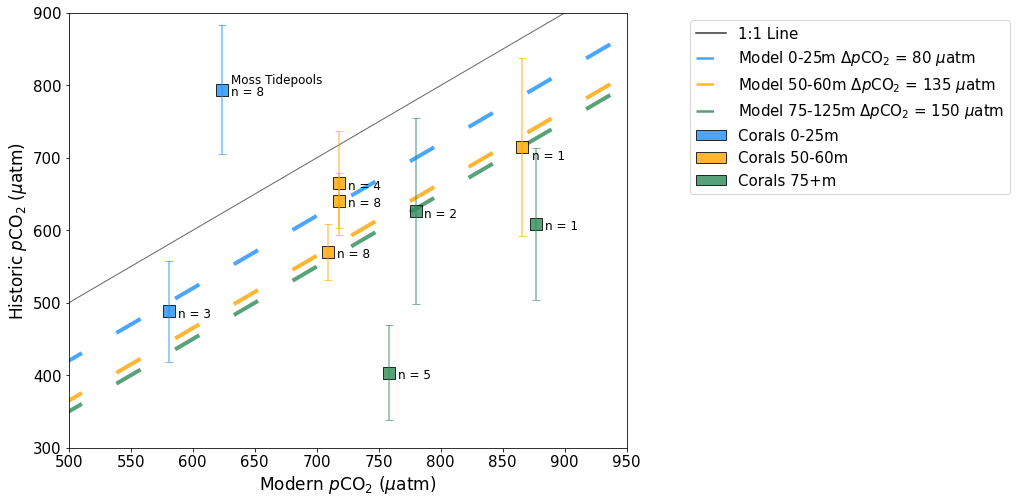

In [18]:
colors = ['orange','seagreen','orange','seagreen','orange','orange',
          'dodgerblue','dodgerblue','seagreen','seagreen']

fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111)

for i in range(0,9):
    site_depth = coral_ph_data['Depth(m)'][i]
    rounded_depth = coral_fxns.round_depth(site_depth)
    site = coral_ph_data['CatalogID'][i]
    catalogID = model_pCO2.index[i]

    if site == 'USNM 92621':
        '''PLOT CORAL DATA'''
        model_pCO2_92621 = 865.96 #this represents the July/August/September model average, as described in Methods
        ax.scatter(model_pCO2_92621,
                   float(corals_pCO2['pCO2_avg (uatm)'].iloc[i]),
                   alpha = 0.8, s = 125, edgecolor = 'black', marker = 's', facecolor = colors[i])
        

        '''PLOT ERROR BARS FOR CORAL DATA'''
        plt.errorbar(model_pCO2_92621,
                     corals_pCO2['pCO2_avg (uatm)'].iloc[i], yerr = corals_pCO2['pCO2_SE'].iloc[i],
                     color = colors[i], capsize = 4, alpha = 0.6, zorder = 2)
        ax.annotate('n = 1', xy = (865.96, 706.34), xytext = (10, -6), textcoords = 'offset points',
                    size = 12, zorder = 10)
        
    else:
        '''PLOT CORAL DATA'''
        ax.scatter(model_pCO2['Modern Summer Mean 3x3 Depth Correction'].iloc[i],
                   float(corals_pCO2['pCO2_avg (uatm)'].iloc[i]),
                   alpha = 0.8, s=125, edgecolor = 'black', marker = 's', facecolor = colors[i])

        '''PLOT ERROR BARS FOR CORAL DATA'''
        plt.errorbar(model_pCO2['Modern Summer Mean 3x3 Depth Correction'].iloc[i],
                     corals_pCO2['pCO2_avg (uatm)'].iloc[i], yerr = corals_pCO2['pCO2_SE'].iloc[i],
                     color = colors[i], capsize = 4, alpha = 0.6, zorder = 2)


'''PLOT LABELS TO SHOW NUMBER OF CORALS AT EACH LOCATION'''
counter = 0
for label, modern_model_pco2, coral, color in zip(coral_ph_data['Number_Corals'][0:9],
                                                  model_pCO2['Modern Summer Mean 3x3 Depth Correction'][0:9],
                                                  corals_pCO2['pCO2_avg (uatm)'][0:9],
                                                  colors[0:9]): 
    site = coral_ph_data['CatalogID'][counter]
    
    if (site != 'USNM 92621'):
        label = 'n = '+str(int(label))
        modern_model_pco2 = modern_model_pco2 + 6 #model_err 
        ax.annotate(label, xy = (modern_model_pco2, coral), xytext=(1, -6),textcoords='offset points',
                    size = 12, zorder = 10)
        
        
        if site == 'USNM 78638':
            ax.annotate('Moss Tidepools', xy = (modern_model_pco2, coral), xytext=(1, 6),textcoords='offset points',
                        size = 12, zorder = 10)        
    
    counter+=1

'''PLOT LINES TO REPRESENT MODEL ESTIMATES OF CENTENNIAL CHANGE IN PCO2'''
if i==8: 
    ax.plot([350,1000], [350,1000], color='k', linewidth=1, alpha = 0.6, zorder = 0)
    ax.plot([350,1000], [350-80, 1000-80], color='dodgerblue', linestyle=(0,(7,10)), linewidth=4, alpha = 0.8, zorder = 0)
    ax.plot([350,1000], [350-135,1000-135], color='orange', linestyle=(0,(7,10)),linewidth=4, alpha = 0.8, zorder = 0)
    ax.plot([350,1000], [350-150, 1000-150], color='seagreen', linestyle=(0,(7,10)),linewidth=4, alpha = 0.8, zorder = 0)
            
            
'''LABEL AXES'''
ax.set_ylim(300,900)
ax.set_xlim(500,950)
ax.set_xlabel('Modern $p$CO$_2$ ($\mu$atm)', size = 17)
ax.set_ylabel('Historic $p$CO$_2$ ($\mu$atm)', size = 17)
ax.legend(bbox_to_anchor=(1.1, 1), prop={'size': 15}, handles = legend_elements)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)